In [29]:
import numpy as np 
import pandas as pd 
import pickle

import time 
import torch 
import torch.nn as nn 
import torch.optim as optim

from tqdm import tqdm
from pynput import keyboard
from IPython.display import clear_output

# visualizatioion pkg 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys
sys.path.append('..')

from utils.viz import viz 
from utils.env import four_room
viz.get_style()

ImportError: this platform is not supported: ('failed to acquire X connection: Display connection closed by server: Connection reset by peer', ConnectionClosedError('server: Connection reset by peer'))

Try one of the following resolutions:

 * Please make sure that you have an X server running, and that the DISPLAY environment variable is set correctly

In [30]:
layout = [
			"wwwwwwwwwwwww",
			"w.....w.....w",
			"w...........w",
			"w.....w.....w",
			"w.....w.....w",
			"w.....w.....w",
			"ww.wwwwwww.ww",
			"w.....w.....w",
			"w.....w.....w",
			"w.....w.....w",
			"w...........w",
			"w.....w.....w",
			"wwwwwwwwwwwww",
		]

key_map = {
    'w': 0,
    's': 1,
    'a': 2,
    'd': 3,
}

class four_room:
    n_row = 13
    n_col = 13

    def __init__(self, cue='H', layout=layout, eps=1e-6, seed=1234):
        # get occupancy 
        self.rng = np.random.RandomState(seed)
        self.layout = layout
        self.cue = cue 
        self.eps = eps 
        self.set_up()
        self.reset()
        
    def set_up(self):
         # get occupancy, current state and goal 
        map_dict = {
            'w': 0,
            '.': 1,
            'S': 0, 
            'G': 0,
        }
        self.objects = [
            np.array([1, 1]),
            np.array([1, 11]), 
            np.array([11, 1]),
            np.array([11, 11]),
        ] 
        self.starts = [
            np.array([5, 5]),
            np.array([5, 7]),
            np.array([7, 5]),
            np.array([7, 7]),
		]
        self.occupancy = np.array([
            list(map(lambda x: map_dict[x], row)) 
            	for row in self.layout])
        walls = np.array([list(row) for row in self.layout])=='w'
        self.walls = [w for w in np.vstack(np.where(walls)).T]

    def reset(self):
        # define MDP 
        self.done = False
        self.rsum = 0
        self.act  = None
        self.traj = []
        self._init_S()
        self._init_A()
        self._init_P()
        self._init_R()
        self.state = self.cell2state(self.curr_cell)
       
        return self.state, None, self.done           
        
    # ------------------ Define MDP --------------- #

    def _init_S(self):
        '''Define the state space
        '''
        self.S2C = {}
        self.C2S = {}
        s = 0
        for i in range(self.occupancy.shape[0]):
            for j in range(self.occupancy.shape[0]):
                if self.occupancy[i, j] == 1:
                    self.S2C[s] = np.array([i, j])
                    self.C2S[(i, j)] = s
                    s += 1
        self.nS = len(self.S2C.keys())
        self.S  = list(self.S2C.keys())
        # get the goal state 
        goal1 = self.objects[self.rng.choice(len(self.objects))]
        self.goal_cells = []
        self.goal_states = []
        dim = 1 if (self.cue == 'H') else 0 
        for obj in self.objects:
            if goal1[dim]==obj[dim]:
                self.goal_cells.append(obj)
                self.goal_states.append(self.C2S[(obj[0], obj[1])])
        # get the current state 
        self.curr_cell = self.starts[self.rng.choice(len(self.starts))]

    def _init_A(self,):
        '''Define the action space 
        '''
        # init 
        self.directs = [
            np.array([-1, 0]), # up
            np.array([ 1, 0]), # down
            np.array([ 0,-1]), # left
            np.array([ 0, 1]), # right
        ]
        self.nA = len(self.directs)
        self.A  = list((range(self.nA)))

    def _init_P(self):
        '''Define the transition function, P(s'|s,a)

            P(s'|s,a) is a probability distribution
        '''

        def p_s_next(s, a):
            p_next = np.zeros([self.nS])
            cell = self.state2cell(s)
            for j in self.A:
                s_next = self.cell2state(
                    np.clip(cell + self.directs[j],
                    0, four_room.n_row-1))
                
                # add probability 
                if j == a:
                    p_next[s_next] += 1-self.eps
                else:
                    p_next[s_next] += self.eps / (self.nA-1)
                
            return p_next
        
        self.p_s_next = p_s_next

    def _init_R(self):
        '''Define the reward function, R(s,a,s')

        return:
            r: reward
            done: if terminated 
        '''
        def R(s):
            r = 1 if s in self.goal_states else 0
            self.rsum += r
            done = True if (self.rsum==2) else False 
            return r, done 
        self.r = R

    def cell2state(self, cell):
        return self.C2S[tuple(cell)]
    
    def state2cell(self, state):
        return self.S2C(state)
        
    # ------------ visualize the environment ----------- #

    def render(self, ax):
        '''Visualize the figure
        '''
        occupancy = np.array(self.occupancy)
        sns.heatmap(occupancy, cmap=viz.grayMap, ax=ax,
                    vmin=0, vmax=1, 
                    lw=.5, linecolor=[.9]*3, cbar=False)
        ax.axhline(y=0, color='k',lw=5)
        ax.axhline(y=occupancy.shape[0], color='k',lw=5)
        ax.axvline(x=0, color='k',lw=5)
        ax.axvline(x=occupancy.shape[1], color='k',lw=5)
        for obj in self.objects:
            c = plt.Circle((obj[1]+.5, obj[0]+.5), radius=.25, color=viz.Red)
            plt.gca().add_artist(c)
        u = plt.Rectangle((self.curr_cell[1]+.25, self.curr_cell[0]+.25), 
                          width=.5, height=.5,
                          fc=viz.Blue, ec=viz.Blue)
        plt.gca().add_artist(u)
        r, _ = self.r(self.state)
        ax.set_title(f'Reward: {r}, done: {self.done}')
        ax.set_axis_off()
        ax.set_box_aspect(1)

    def show_pi(self, ax, pi):
        self.reset()
        self.render(ax)
        for s in self.S:
            if s not in self.s_termination:
                cell = self.state2cell(s)
                a = pi[s].argmax()
                next_cell = self.directs[a]*.25
                ax.arrow(cell[1]+.5, cell[0]+.5, 
                        next_cell[1], next_cell[0],
                        width=.01, color='k')
        ax.set_title('Policy')

    def show_v(self, ax, V):
        v_mat = V.reshape([four_room.n_row, four_room.n_col])
        sns.heatmap(v_mat, cmap=viz.RedsMap, ax=ax,
                    lw=.5, linecolor=[.9]*3, cbar=False)
        ax.axhline(y=0, color='k',lw=5)
        ax.axhline(y=v_mat.shape[0], color='k',lw=5)
        ax.axvline(x=0, color='k',lw=5)
        ax.axvline(x=v_mat.shape[1], color='k',lw=5)
        for s in self.S:
            if s not in self.s_termination:
                    cell = self.state2cell(s)
                    v = V[s].round(2)
                    ax.text(cell[1]+.15, cell[0]+.65,
                            str(v), color='k',
                            fontweight='bold', fontsize=8)
        ax.set_title('Value')
        ax.set_axis_off()
        ax.set_box_aspect(1)
    
    def step(self, act):
        # get the next state 
        p_s_next = self.p_s_next(self.state, act)
        self.state = self.rng.choice(self.S, p=p_s_next)
        self.curr_cell = self.state2cell(self.state)
        rew, self.done = self.r(self.state)
        self.act = None 
        self.traj.append(self.curr_cell.copy())
        return self.state, rew, self.done
    
    def on_release(self, key):
        if key == keyboard.Key.esc:
            # Stop listener
            return False

    def wait_until(self):
        while not self.act in [0, 1, 2, 3]:
            time.sleep(.1) 
        return self.act 
	

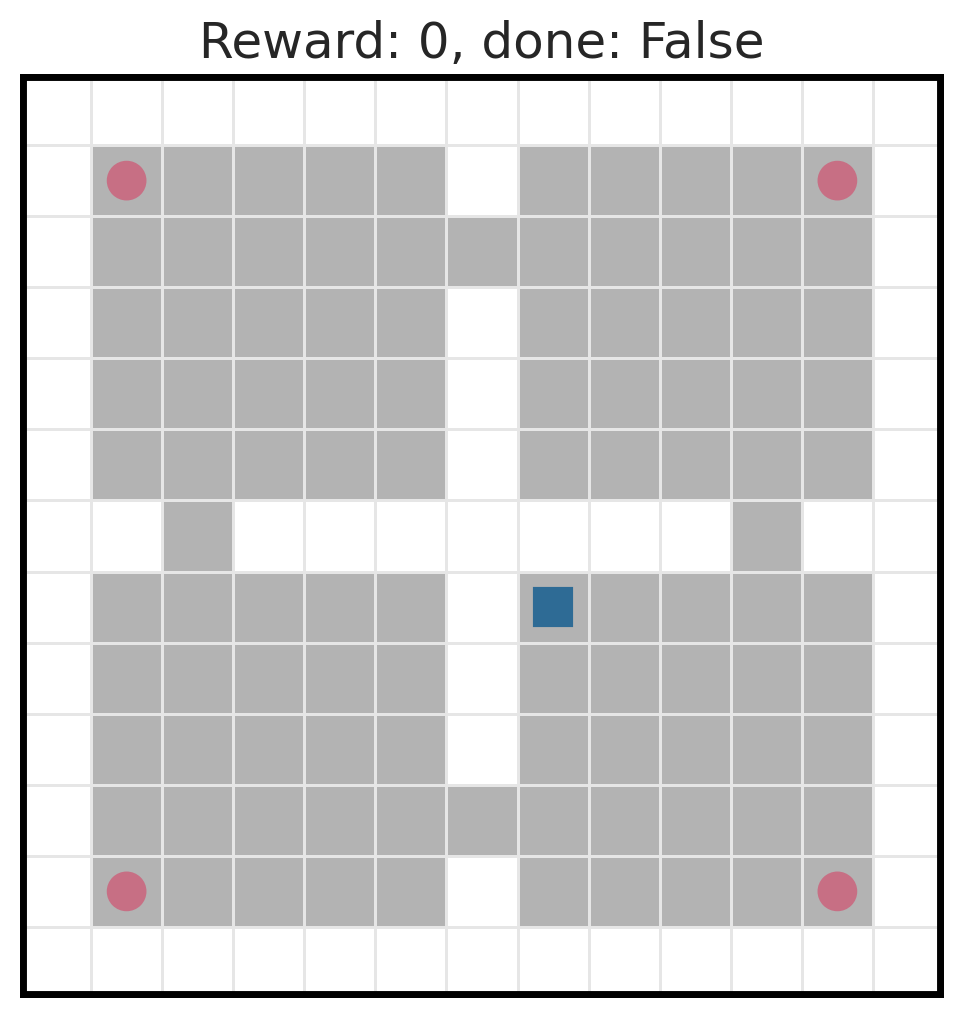

In [26]:
env = four_room()
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
env.render(ax)

In [ ]:
env.step()